In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from PIL import Image

In [2]:
def show(matrix):
    plt.imshow(matrix, vmin=matrix.min(), vmax=matrix.max())
    plt.show()

In [3]:
def make_animation(save_name, frames, interval, fps):
    
    # First set up the figure, the axis, and the plot element we want to animate
    side_length = frames[0].shape[0]
    fig = plt.figure()
    ax = plt.axes(xlim=(0, side_length), ylim=(0, side_length))
    im=plt.imshow(frames[0], vmin=frames[0].min(), vmax=frames[0].max())

    # initialization function: plot the background of each frame
    def init():
        im.set_data(np.zeros_like(frames[0]))
        return [im]

    # animation function.  This is called sequentially
    def animate(i):
        im.set_data(frames[i])
        im.set_clim(vmin=frames[i].min(), vmax=frames[i].max())
        return [im]

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(frames), interval=interval, blit=True)

    anim.save(save_name, fps=fps, writer='pillow')

In [4]:
def initialize_cave(side_length, walls_pct):
    cave = np.zeros((side_length, side_length))
    for row in range(cave.shape[0]):
        for col in range(cave.shape[1]):
            if np.random.rand() < walls_pct:
                cave[row, col] = 1
    return cave

In [5]:
def get_square_mask(cave, pos, radius):
    side_length = cave.shape[0]
    row, col = pos
    row_min = max(0, row - radius)
    row_max = min(side_length - 1, row + radius)
    col_min = max(0, col - radius)
    col_max = min(side_length - 1, col + radius)
    return cave[row_min:row_max+1, col_min:col_max+1]

In [6]:
def apply_rule1(cave, radius, thresh):
    side_length = cave.shape[0]
    for row in range(1, side_length-1):
        for col in range(1, side_length-1):
            pos = (row, col)
            nearest1 = get_square_mask(cave, pos, radius)
            
            if nearest1.sum().sum() >= thresh:
                cave[row, col] = 1
    

In [7]:
def apply_rule2(cave, radius, thresh):
    side_length = cave.shape[0]
    for row in range(1, side_length-1):
        for col in range(1, side_length-1):
            pos = (row, col)
            nearest1 = get_square_mask(cave, pos, radius)
            
            if nearest1.sum().sum() <= thresh:
                cave[row, col] = 0
    

In [42]:
RULE1_ITERS = 4
RULE2_ITERS = 3

SIDE_LENGTH = 60
WALLS_PCT = 0.35

cave_frames = []

rule1_thresh, rule1_radius = 6, 1
rule2_thresh, rule2_radius = 3, 1


cave = initialize_cave(SIDE_LENGTH, WALLS_PCT)
cave_frames.append(np.copy(cave))

for it in range(RULE1_ITERS):
    apply_rule1(cave, rule1_radius, rule1_thresh)
    cave_frames.append(np.copy(cave))
    
for it in range(RULE2_ITERS):
    apply_rule2(cave, rule2_radius, rule2_thresh)
    cave_frames.append(np.copy(cave))
    
cave[0, :] = 0
cave[:, 0] = 0
cave[SIDE_LENGTH-1, :] = 0
cave[:, SIDE_LENGTH-1] = 0
apply_rule2(cave, rule2_radius, rule2_thresh)

cave_frames.append(np.copy(cave))

    

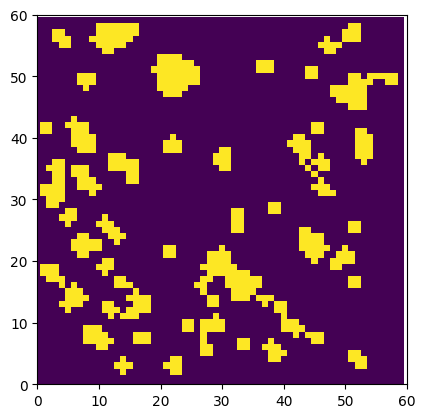

In [43]:
make_animation(f"cave_formation_wallpct{int(WALLS_PCT*100)}.gif", cave_frames, 1000, 1)

In [44]:
def update_cave_with_particles(cave, particles):
    cave_new = np.zeros_like(cave)
    for pos in particles:
        row, col = pos
        cave_new[row, col] += 1/(len(particles))
    
    cave_new = cave_new + (np.copy(cave) * cave_new.max()*1.25)
    
    
    return cave_new

Iteration 0:


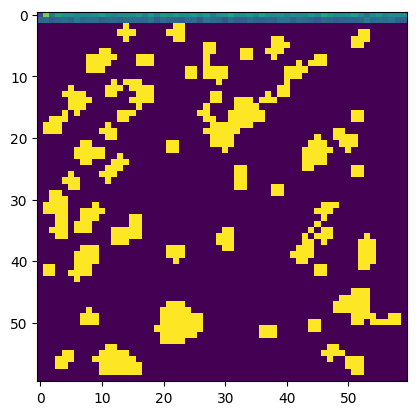

Iteration 500:


Iteration 1000:


In [49]:
particles_frames = []

NUM_PARTICLES = 10000
particles = [(0, i%SIDE_LENGTH) for i in range(NUM_PARTICLES)]

particles_frames.append(update_cave_with_particles(cave, particles))

PARTICLE_ITERS = 1000
MOVE_DOWN_PROB = 0.8

for p_i in range(PARTICLE_ITERS+1):
    for idx in range(len(particles)):
        curr_particle = particles[idx]
        row_orig, col_orig = curr_particle
        row_new, col_new = curr_particle
        
        r = np.random.random()
        
        if 0.0 <= r < MOVE_DOWN_PROB/2:
            # move down
            row_new = row_orig + 1
        elif MOVE_DOWN_PROB/2 <= r < 0.5:
            # move up
            row_new = row_orig - 1
        elif 0.5 <= r < 0.75:
            # move right
            col_new = col_orig + 1
        elif 0.75 <= r < 1:
            # move left
            col_new = col_orig - 1
        
        
        if row_new <= 0 or row_new >= SIDE_LENGTH:
            row_new = row_orig
        if col_new <= 0 or col_new >= SIDE_LENGTH:
            col_new = col_orig
        if cave[row_new, col_new] == 1:
            row_new, col_new = row_orig, col_orig
        
        particles[idx] = (row_new, col_new)
        
    particles_frames.append(update_cave_with_particles(cave, particles))
    
    if p_i % 500 == 0:
        print(f"Iteration {p_i}:")
        show(particles_frames[-1])



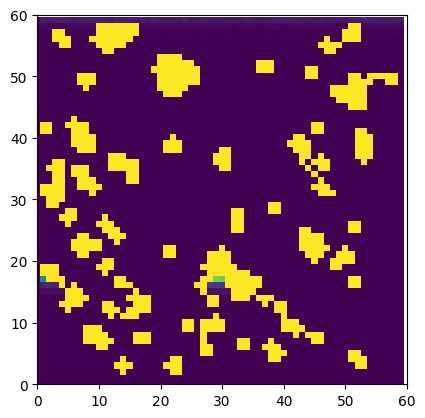

In [50]:
make_animation(f"particle_diffusion_wallpct{int(WALLS_PCT*100)}_movedown{int(MOVE_DOWN_PROB*100)}.gif", particles_frames, 20, 50)